In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca
import objects


In [2]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.308725,0.235825,0.566757,0.982782,0.707526,1.000000,0.410887,0.671068,1.000000,0.438527
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.000000,0.861588,0.000000,0.640911,0.020238,0.220356,0.632252,0.000000,0.488578
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.491401,0.279122,0.555258,0.000000,0.392175,0.000000,0.116289,0.000000,0.260194,0.531400
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.604918,0.598850,0.621841,0.000000,0.519941,0.000000,0.342185,0.416527,0.000000,0.545708
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.470835,0.670696,0.555250,0.000000,0.390923,0.000000,0.498504,0.449224,0.000000,0.689242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.669319,0.770253,0.702931,0.000000,0.451846,0.000000,0.319644,0.549587,0.000000,0.935108
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.747236,0.742399,0.730485,0.000000,0.680460,0.000000,0.280413,0.529434,0.000000,0.606330
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.422981,0.769213,0.625325,0.000000,0.374319,0.000000,0.396084,0.590976,0.238307,0.753111


In [3]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.775985,0.973492,0.472825,0.0,0.269797,0.0,0.539781,0.290165,0.000000,0.722611
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.582213,0.531660,0.540145,0.0,0.322049,0.0,0.303573,0.133159,0.000000,0.537012
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.907365,0.736128,-0.336653,0.0,-0.069528,0.0,0.176989,0.766373,0.000000,1.094845
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.648501,0.789699,0.836996,0.0,0.285660,0.0,0.320280,0.488913,0.000000,0.674738
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.493294,0.566990,0.807264,0.0,0.471971,0.0,0.462733,0.508932,0.000000,0.693707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.550182,0.719685,0.701615,0.0,0.225656,0.0,0.295914,0.701896,0.000000,0.709542
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.819116,0.689739,0.213157,0.0,0.969447,0.0,0.134090,0.710444,0.000000,0.846294
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.417027,0.734039,0.683655,0.0,0.369566,0.0,0.405814,0.575430,0.000000,0.653918


In [4]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [5]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [6]:
# compound_model = keras.models.load_model('cd_clf')

In [7]:
# compound_model.summary()

## SHAP evaluation

In [8]:
x_test_scaled.iloc[:2,:2]

,AADAC,APOA1
Patient_ID,,
253_CD_plain,0.869185,0.841880
105_CD_plain,0.853562,0.933532


In [9]:
import objects

In [10]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True)

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


link.f
link.f
link.f
link.f


## Calculate SHAP values

In [11]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [12]:
# shap_values

## Save SHAP values

In [13]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [14]:


with open("../data/models/shap/all_ind_2p11", "rb") as fp:   # Unpickling
# with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [15]:
shap_values = shap_values[0]


In [16]:
# for i in range(3):
#     shap_values[i] /= 100

In [17]:
shap_values

[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.86557971,  0.        ],
        [ 0.        ,  0.28436877,  0.12097102, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         -0.50817297,  0.        ],
        ...,
        [ 0.16492742,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.84851677, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.27735457, ..., -0.24787611,
         -0.2521452 ,  0.        ]]),
 array([[-0.45407953, -3.24016339,  2.32379255, ..., -1.66021678,
          0.        , -1.41715436],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-7.11025483, -4.44871269, -0.97568573, ..., -4.79584417,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [18]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (78, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [19]:
idx = 41
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
260_CD_deep_ulcer,0.588189,0.625309,0.750597,0.746795,0.678619,0.578012,0.191236,0.321755,0.595506,0.569387,...,0.73261,0.822309,0.569633,0.0,0.590696,0.0,0.341364,0.322348,0.0,0.664423


In [20]:
gmm_model_get_prediction_ae(patient)[0]

array([2.25685074e-14, 8.20535540e-01, 1.79464460e-01])

In [21]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:",np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [2.25685074e-14 8.20535540e-01 1.79464460e-01]
Predicted class: 1


#### Control

In [22]:
import shap

In [23]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], patient, link="logit")

####  CD no ulcer

In [24]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [25]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [26]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

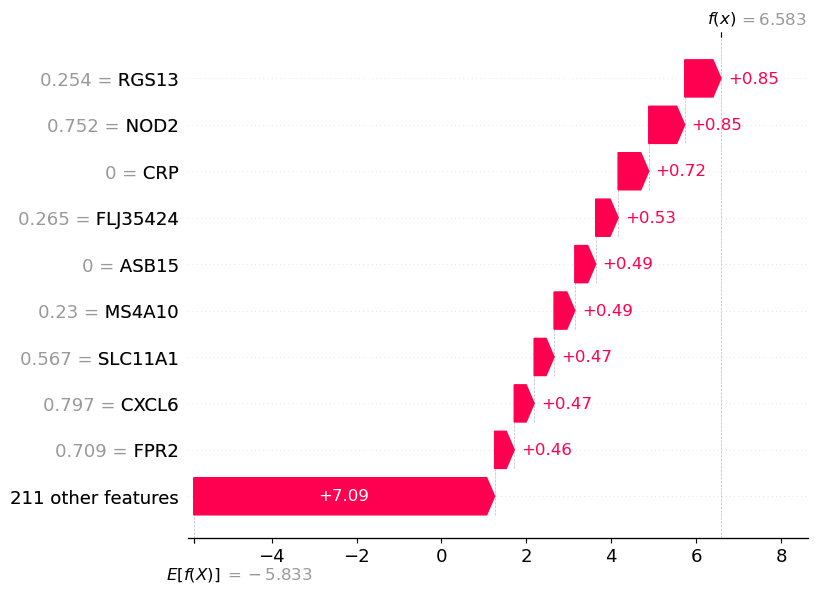

In [27]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [28]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [29]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [30]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

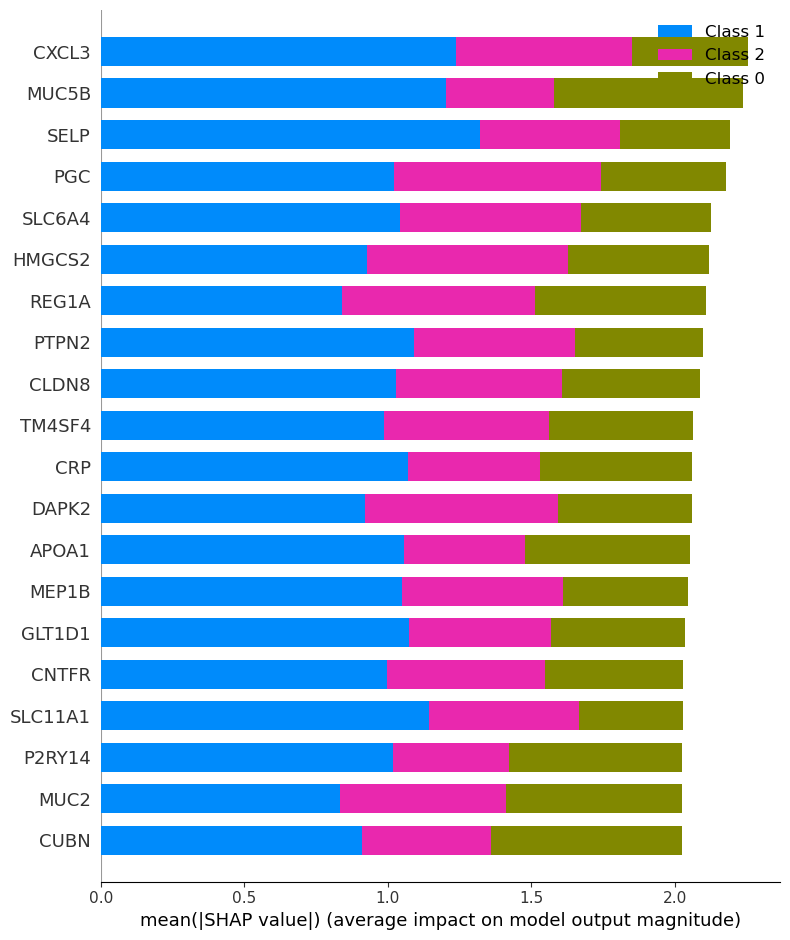

In [31]:
shap.summary_plot(shap_values, x_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


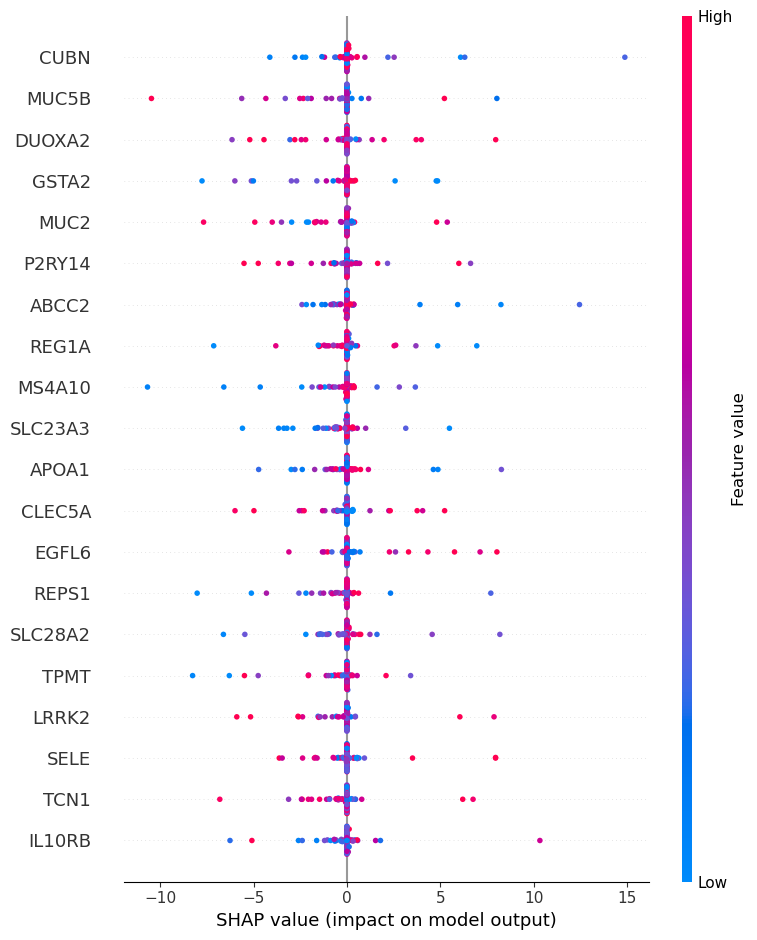

In [32]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

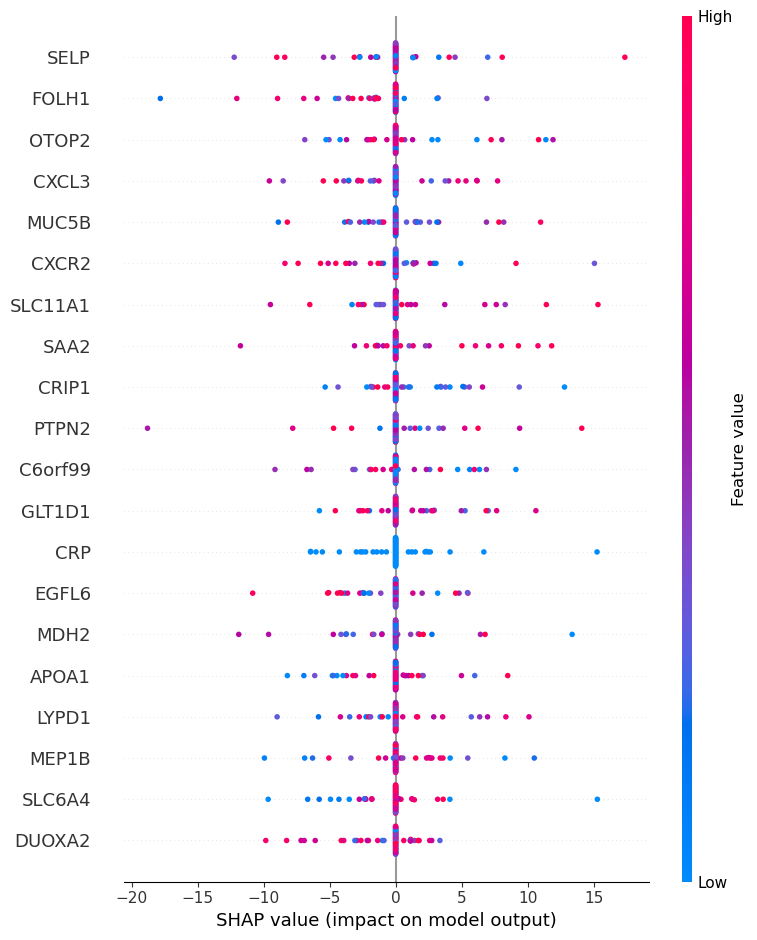

In [33]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

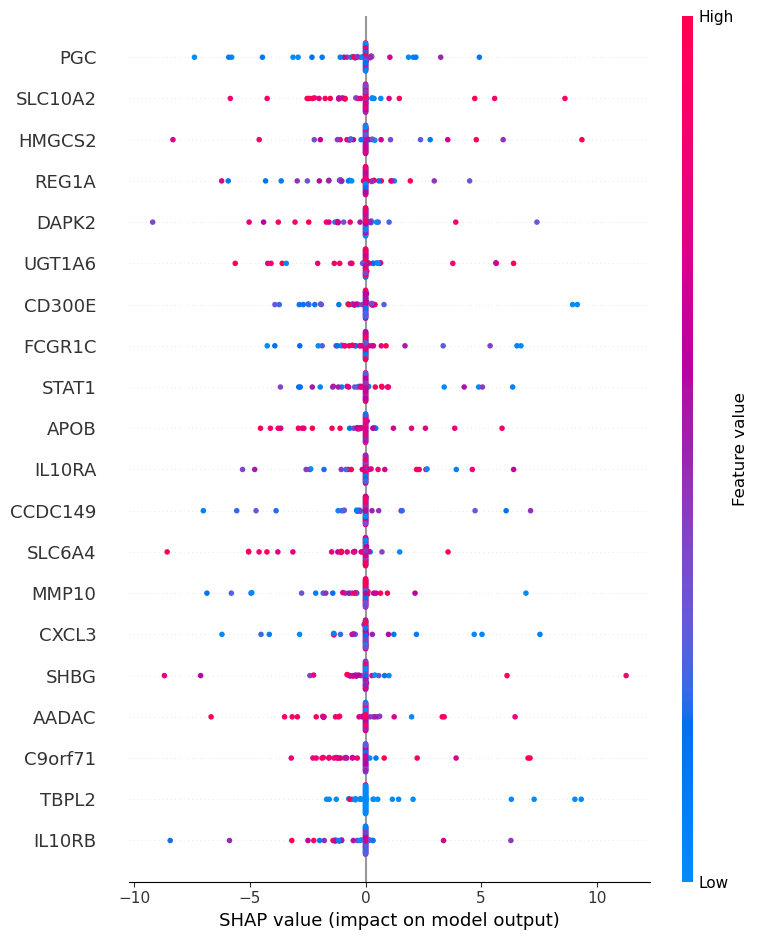

In [34]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

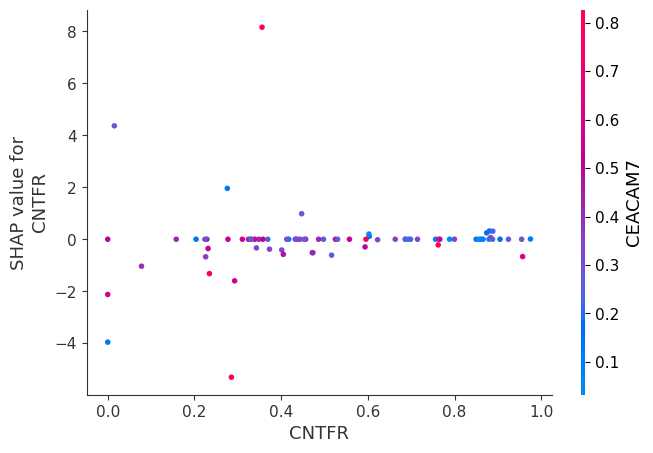

In [35]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

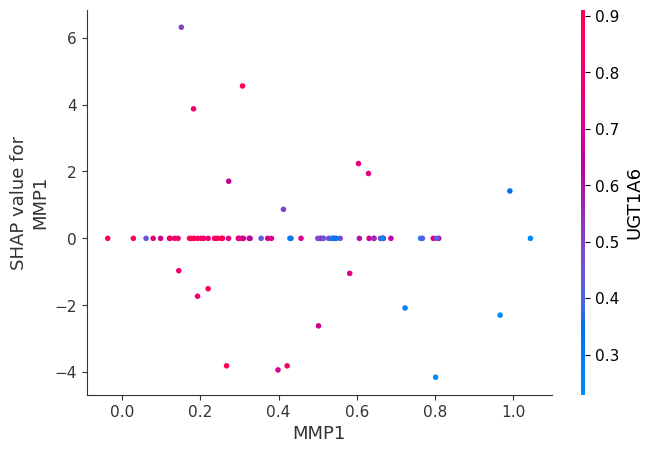

In [36]:
# CD no ulcer
shap.dependence_plot("MMP1", shap_values[1], x_test_scaled)

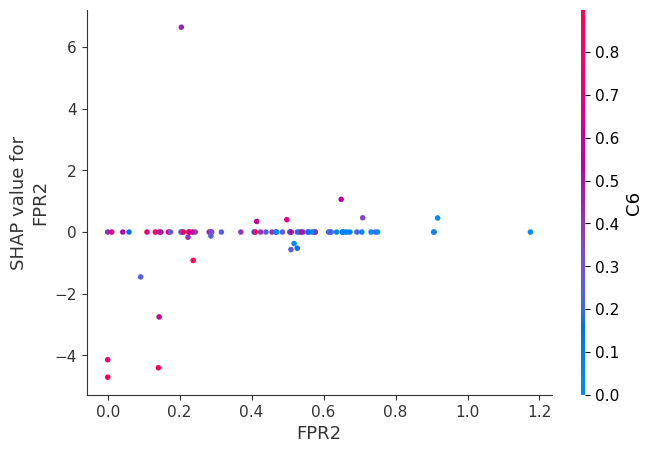

In [37]:
# CD deep ulcer
shap.dependence_plot("FPR2",shap_values[2], x_test_scaled)

## Clustering

In [38]:
disease_labels_test.shape

(78,)

In [39]:
# sys.stdout = open(1, 'w')
import sys
stdout = sys.stdout
sys.stdout = sys.__stdout__

### Current SHAP functionality

In [40]:
clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
No/low signal found from feature 13 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 78%|██████████████████████████████████████████████████████████████▌                 | 172/220 [01:10<00:19,  2.46it/s]No/low signal found from feature 171 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 172 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
 98%|██████████████████████████████████████████████████████████████████████████████▌ | 216/220 [01:26<00:01,  3.25it/s]No/low signal found from feature 215 (this is typically cause

In [41]:
# clustering

In [42]:
# clustering.shape

In [43]:
row = 77
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

# patient 8: explanations for CD deep ulcer diagnosis

In [44]:
type(exp)

shap._explanation.Explanation

In [45]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [46]:

# with open("../clust", "rb") as fp:   # Unpickling
#     clustering = pickle.load(fp)

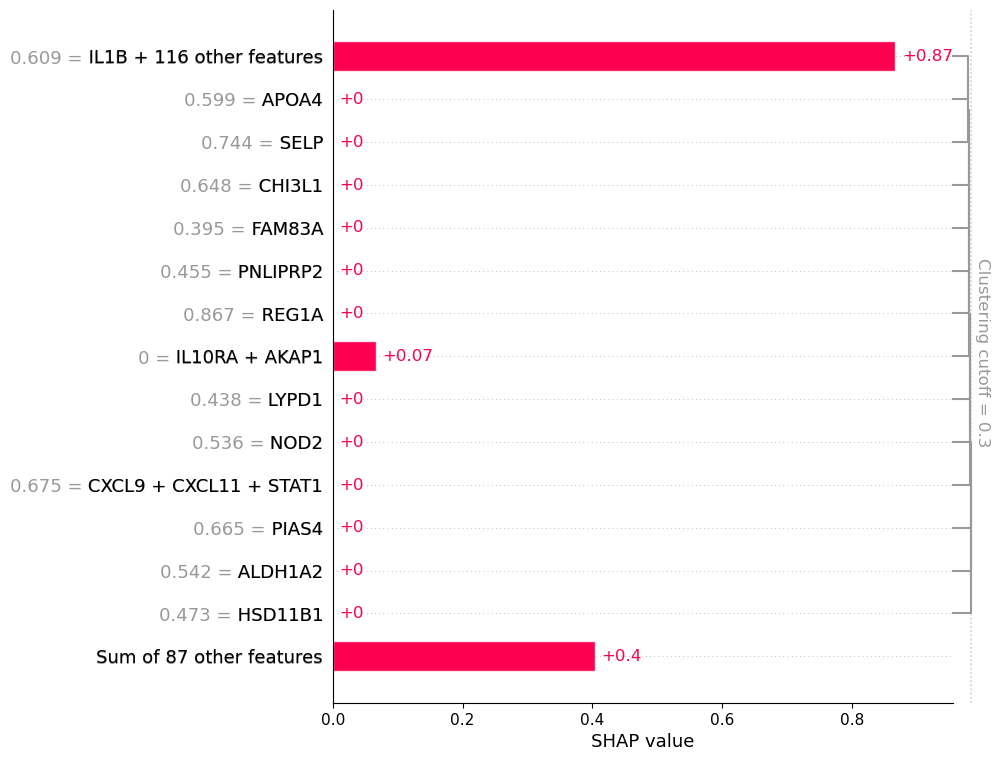

In [47]:
import shap
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, max_display=15, clustering_cutoff=0.3,
               clustering=clustering)

## Hierarchical clustering of genes based on shap values, across all patients with given disease classification

In [48]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaders, fcluster
import seaborn as sns

In [49]:


all_gene_df = pd.DataFrame(shap_values[2], index=x_test_scaled.index, columns = x_test_scaled.columns)
df_cd_deep = all_gene_df[all_gene_df.index.str.endswith('_CD_deep_ulcer')]
df_cd_plain = all_gene_df[all_gene_df.index.str.endswith('_CD_plain')]
df_control = all_gene_df[all_gene_df.index.str.endswith('_control')]
df_cd_deep

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,HDLBP,PIAS4,ADH1B,LOC100507531,FAM83A,NXF4,RNF125,DARS,DNAI1,MBTPS1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
62_CD_deep_ulcer,0.000000,0.000000,-0.614844,0.000000,-0.373574,0.518292,-0.599821,0.765439,0.000000,-1.705416,...,0.168711,0.000000,0.687993,0.351322,0.151260,0.203394,0.000000,0.417006,0.000000,-0.410442
167_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.191482,0.276537,0.273758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
196_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101371,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.204316,0.000000
23_CD_deep_ulcer,0.000000,0.888134,0.000000,0.314335,0.000000,0.000000,0.000000,0.000000,0.000000,0.123318,...,0.000000,0.000000,0.000000,0.652464,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
93_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
229_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.034305,0.189989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
46_CD_deep_ulcer,0.000000,0.000000,0.000000,0.000000,0.219866,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.317991,0.000000,0.000000,0.000000,0.000000,0.000000,0.149328,0.000000,0.000000
176_CD_deep_ulcer,0.000000,0.051185,0.334689,0.000000,0.156036,0.030290,0.000000,0.000000,0.000000,0.114060,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026622,0.000000
49_CD_deep_ulcer,0.000000,0.000000,-1.116392,-0.690025,0.000000,0.000000,0.000000,0.000000,-0.228842,0.000000,...,0.000000,-1.606258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Example: CD deep ulcer patients

In [50]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_deep = linkage(df_cd_deep.T, 'ward', metric='euclidean', optimal_ordering=True)

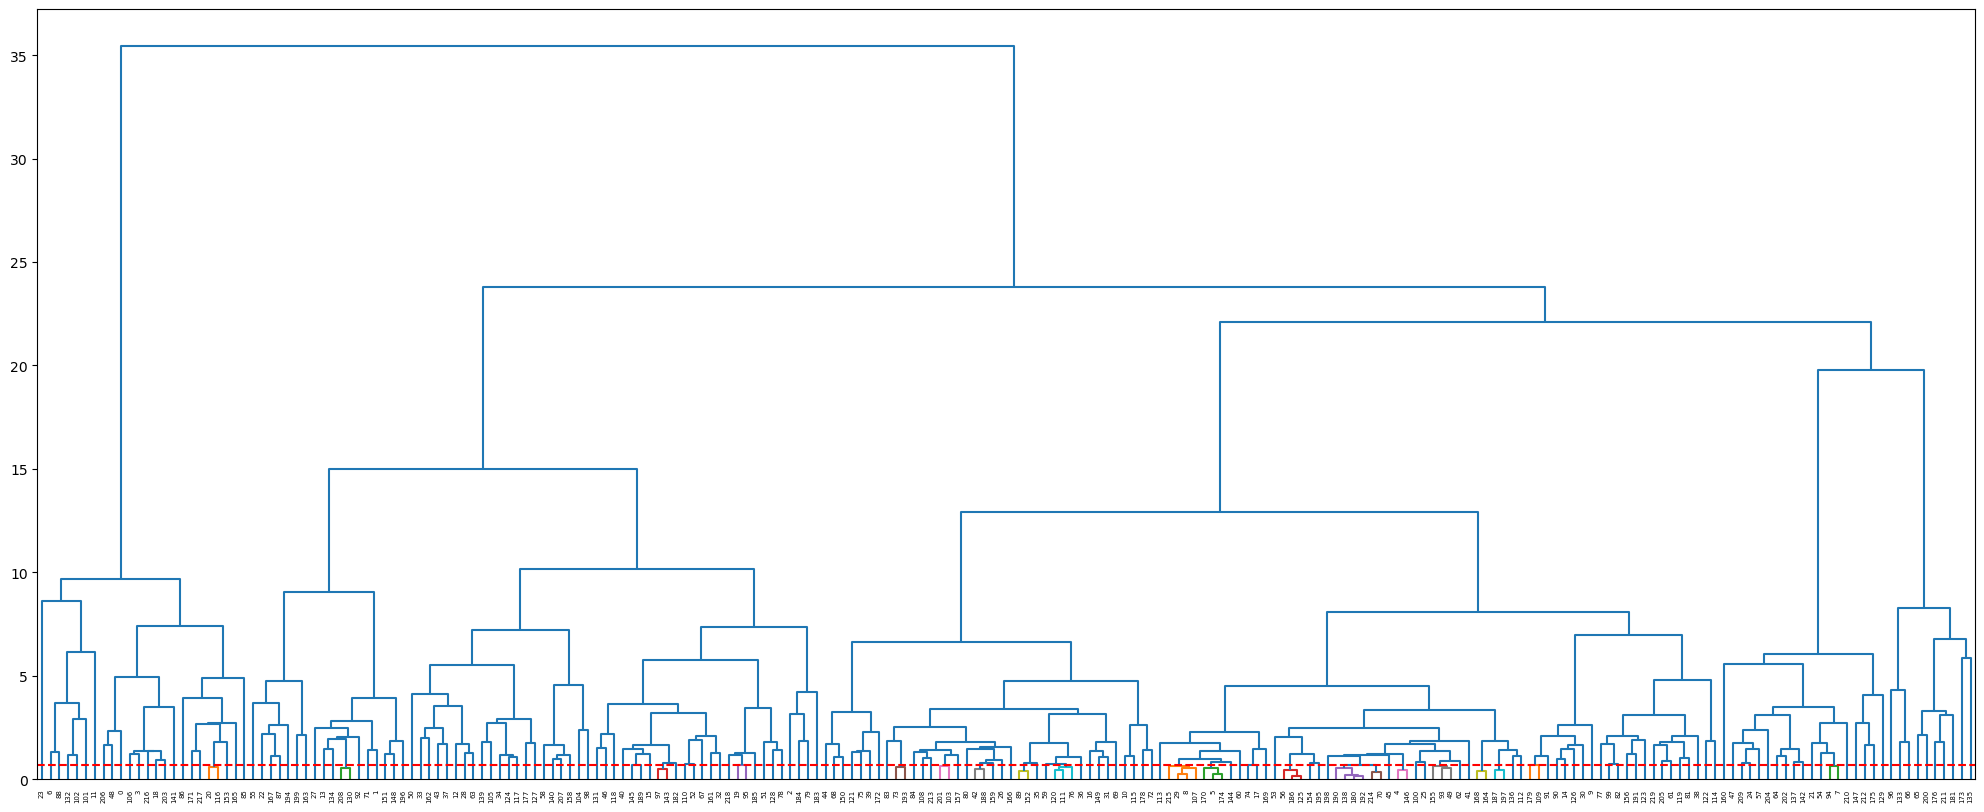

In [51]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = .7, get_leaves=True)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [52]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([ 23,   6,  88, 132, 102, 101,  11, 206,  48,   0, 106,   3, 216,
        18, 203, 141,  86, 171, 217,  20, 116, 153, 165,  85,  55,  22,
       167,  87, 194, 199, 163,  27,  13, 134, 208, 130,  92,  71,   1,
       151, 148, 196,  50,  33, 162,  43,  37,  12,  28,  63, 139, 105,
        34, 124, 117, 177, 127,  58, 140, 207, 158, 104,  98, 131,  46,
       118,  40, 145, 189,  15,  97, 143, 182, 110,  52,  67, 161,  32,
       218,  19,  95, 185,  51, 128,  78,   2, 184,  79, 183,  44,  68,
       150, 121,  75,  39, 172,  83,  73, 193,  84, 108, 213, 201, 103,
       157,  80,  42, 188, 159,  26, 166,  89, 152,  35,  59, 120, 111,
        76,  36,  16, 149,  31,  69,  10, 115, 178,  72, 113, 215,  29,
         8, 107, 170,   5, 174, 144,  60,  74,  17, 169,  53,  56, 186,
       125, 154, 195, 198, 190, 138, 180, 192, 214,  70,  45,   4, 146,
       100,  25, 155,  93,  49,  62,  41, 168, 164, 187, 197, 136, 112,
       179, 109,  91,  90,  14, 126,  30,   9,  77,  99,  82, 15

In [53]:
df_cd_deep.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'HDLBP', 'PIAS4', 'ADH1B', 'LOC100507531', 'FAM83A', 'NXF4', 'RNF125',
       'DARS', 'DNAI1', 'MBTPS1'],
      dtype='object', length=220)

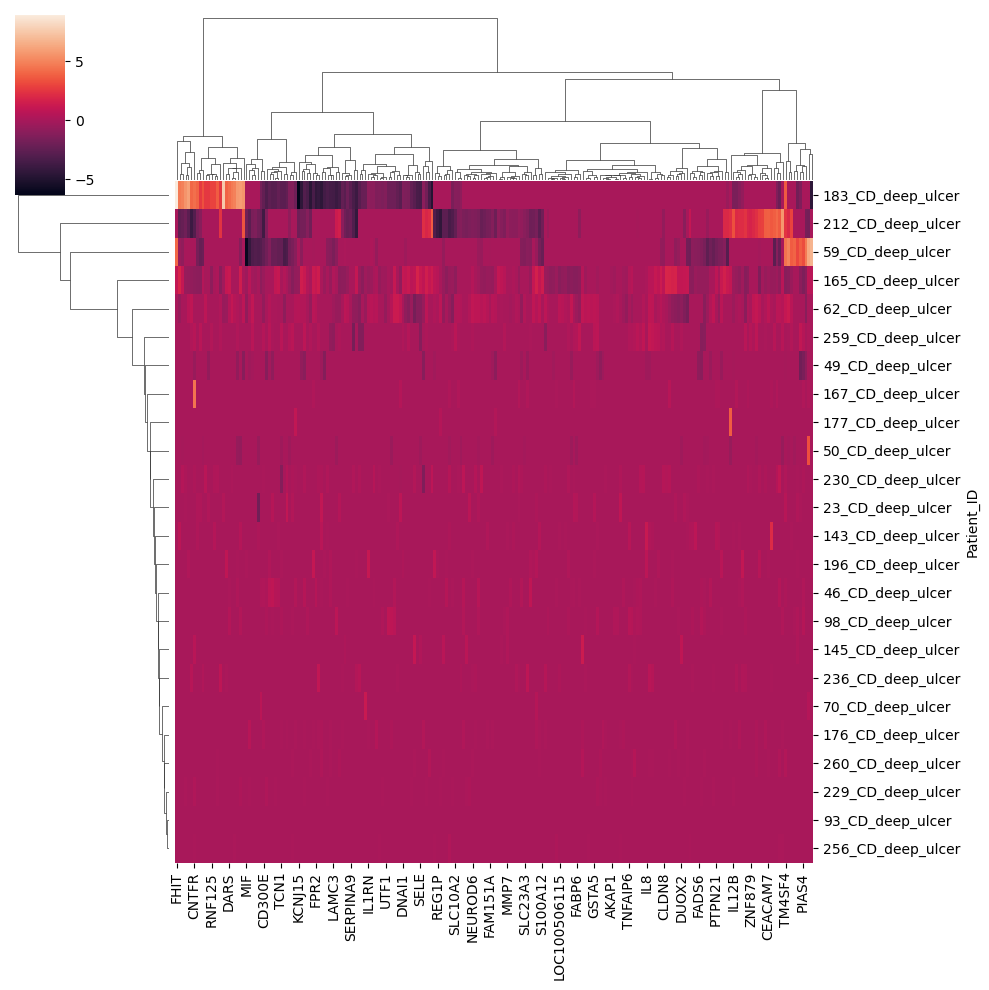

In [54]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_deep, col_linkage=gene_cluster_cd_deep)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [55]:
gene_cluster_cd_deep

array([[1.80000000e+02, 1.92000000e+02, 1.60818988e-01, 2.00000000e+00],
       [1.86000000e+02, 1.25000000e+02, 1.67317766e-01, 2.00000000e+00],
       [1.38000000e+02, 2.20000000e+02, 2.23705485e-01, 3.00000000e+00],
       [2.90000000e+01, 8.00000000e+00, 2.53087014e-01, 2.00000000e+00],
       [5.00000000e+00, 1.74000000e+02, 2.71292546e-01, 2.00000000e+00],
       [2.14000000e+02, 7.00000000e+01, 3.46345634e-01, 2.00000000e+00],
       [1.68000000e+02, 1.64000000e+02, 3.87654687e-01, 2.00000000e+00],
       [8.90000000e+01, 1.52000000e+02, 4.13848507e-01, 2.00000000e+00],
       [1.20000000e+02, 1.11000000e+02, 4.31250031e-01, 2.00000000e+00],
       [1.87000000e+02, 1.97000000e+02, 4.47541651e-01, 2.00000000e+00],
       [5.60000000e+01, 2.21000000e+02, 4.54340093e-01, 3.00000000e+00],
       [4.00000000e+00, 1.46000000e+02, 4.55494549e-01, 2.00000000e+00],
       [9.70000000e+01, 1.43000000e+02, 4.81386176e-01, 2.00000000e+00],
       [4.20000000e+01, 1.88000000e+02, 4.93190211e

In [56]:
cluster_labels = fcluster(gene_cluster_cd_deep, .7, criterion='distance')
# label = fcluster(gene_cluster_cd_deep, 8, criterion='maxclust')
cluster_labels.shape

(220,)

In [57]:
leaders(gene_cluster_cd_deep, cluster_labels)

(array([  6,  88, 132, 102, 101,  11,  23, 206,  48,   0, 106,   3,  18,
        203, 216, 141, 171, 217, 239, 153, 165,  86,  85, 167,  87,  22,
        194,  55, 199, 163,  13, 134, 235,  92,  27,  71,   1, 151, 148,
        196,  33, 162,  43,  37,  28,  63,  12,  50, 139, 105, 124, 117,
         34, 177, 127, 140, 207, 158,  58, 104,  98, 131,  46, 118, 145,
        189,  15,  40, 232, 182, 110,  52,  67, 161,  32, 218, 246, 185,
        128,  78,  51, 184,  79,   2, 183,  68, 150,  44, 121,  75,  39,
        172,  83, 240, 108, 213,  84, 243, 157, 233, 159,  26,  80, 166,
        227,  35,  59, 241,  36, 149,  31,  16,  69,  10, 115, 178,  72,
        234, 144, 242,  60, 113,  74,  17, 169, 154, 195, 230,  53, 237,
        225, 198,  45, 231, 100,  25, 245,  62,  41, 136, 112, 229, 226,
        247,  91,  90,  14, 126,  30,   9,  99,  82,  77, 156, 191, 123,
        205,  61, 219, 119,  81,  38, 122, 114, 209,  24,  57,  47, 204,
         64, 202, 137, 142,  54, 244,  21, 210, 160

In [58]:
leader_ids = leaders(gene_cluster_cd_deep, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  77,  76,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  94,  93,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 108, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       119, 120, 118, 121, 122, 123, 124, 125, 127, 128, 126, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 142, 143, 141, 140,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 175, 174, 176, 177, 178, 179, 180, 18

In [59]:
cluster_labels

array([ 10,  37,  84,  12, 134, 119,   1, 174, 118, 150, 114,   6,  47,
        31, 147,  67, 112, 124,  13,  76,  19, 176,  26,   7, 166, 136,
       102,  35,  45, 118, 149, 111,  75,  41,  53, 106, 109,  44, 162,
        91,  68, 139, 100,  43,  88, 133,  63, 168,   9, 137,  48,  81,
        72, 129, 175,  28, 126, 167,  59, 108, 121, 158, 138,  46, 170,
       186, 184,  73,  86, 113, 131,  36, 117,  93, 123,  90, 107, 153,
        80,  83, 103, 161, 152,  94,  97,  23,  22,  25,   2, 105, 146,
       145,  34, 137, 174,  76, 185,  69,  61, 151, 135,   5,   4,  98,
        60,  50,  11, 118,  95, 144,  71, 107, 143, 122, 164, 115,  19,
        52,  64, 160, 107,  89, 163, 156,  51, 126, 148,  55,  79, 182,
        33,  62,   3, 183,  32, 192, 142, 172, 130,  49,  56,  16, 173,
        69, 120,  65, 134, 181,  39, 110,  87,  38, 105,  20, 127, 137,
       154,  99,  58, 101, 178,  74,  42,  30, 140,  21, 104,  24, 140,
       125, 119,  17,  92, 191, 119, 180, 188,  54, 116, 144, 13

In [60]:
df_cd_deep.columns.get_loc("OSM")

63

In [61]:
np.where(cluster_labels == 2) #osm

(array([88], dtype=int64),)

In [62]:
gene_df = df_cd_deep.describe().T
gene_df['gene_symbol']  = df_cd_deep.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,24.0,0.074390,0.826918,-2.136063,0.0,0.0,0.0,3.316344,AADAC,10
APOA1,24.0,-0.177166,0.842161,-3.208808,0.0,0.0,0.0,0.888134,APOA1,37
APOA4,24.0,-0.031365,0.677906,-1.445793,0.0,0.0,0.0,2.233765,APOA4,84
APOB,24.0,0.092267,0.554791,-0.690025,0.0,0.0,0.0,2.590099,APOB,12
APOC3,24.0,-0.009304,0.106541,-0.373574,0.0,0.0,0.0,0.219866,APOC3,134
...,...,...,...,...,...,...,...,...,...,...
NXF4,24.0,-0.026476,0.165062,-0.628421,0.0,0.0,0.0,0.203394,NXF4,118
RNF125,24.0,0.099149,0.634107,-0.894187,0.0,0.0,0.0,2.926396,RNF125,15
DARS,24.0,0.267171,0.885506,0.000000,0.0,0.0,0.0,4.237879,DARS,18
DNAI1,24.0,0.006516,0.361789,-1.345460,0.0,0.0,0.0,1.054501,DNAI1,77


In [63]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,0.074390,10,AADAC
APOA1,-0.177166,37,APOA1
APOA4,-0.031365,84,APOA4
APOB,0.092267,12,APOB
APOC3,-0.009304,134,APOC3
...,...,...,...
NXF4,-0.026476,118,NXF4
RNF125,0.099149,15,RNF125
DARS,0.267171,18,DARS
DNAI1,0.006516,77,DNAI1


In [64]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,0.074390,10,AADAC
APOA1,-0.177166,37,APOA1
APOA4,-0.031365,84,APOA4
APOB,0.092267,12,APOB
APOC3,-0.009304,134,APOC3
...,...,...,...
NXF4,-0.026476,118,NXF4
RNF125,0.099149,15,RNF125
DARS,0.267171,18,DARS
DNAI1,0.006516,77,DNAI1


In [65]:
def group_labels(x):
    if len(x) > 4:
        gene_list = x[:4]
    else:
        gene_list = x
    return ", ".join(gene_list)

def add_other(num, curr_label, max_display=4):
#     print(type(num))
#     print(type(curr_label))
    if num > 1:
        if num > 2: 
            other = " others" 
            num_displayed = min(num, max_display)
        else:
            num_displayed = 2
            other = " other"
        rem = num - num_displayed
        if rem == 0:
            return curr_label
        return curr_label + " + " + str(rem) + other
    else:
        return curr_label


In [66]:

def get_idx_order(dn_ids, df, agg_df):
    g_symbols = np.array(df.columns)
    g_symbols = g_symbols[dn_ids]
    
    genes_from_groups = []
    for li in agg_df["grouped_genes"].values:
        genes_from_groups.append(li[0])
        
    positions_in_dend = [np.where(g_symbols == gene)[0][0] for gene in genes_from_groups]
    idxs = np.arange(1,agg_df.shape[0]+1)
    sorted_idxs = [x for _,x in sorted(zip(positions_in_dend,idxs))]
    return sorted_idxs

In [67]:
# agg_df = mean_df.groupby(['cluster_labels']).agg([group_labels, 'sum', 'count'])
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', list))

def group_fn(data):
    d = {}
    mean_vals = data['mean']
    symbols = list(data['gene_symbol'])
    print(mean_vals)
    print(symbols)
    mean_dict = {symbols[i]: abs(mean_vals[i]) for i in range(len(symbols))}
#     print(mean_dict)
    gene_dict = dict(sorted(mean_dict.items(), key=lambda x : x[1], reverse=True))
    gene_list = list(gene_dict.keys())
#     print(gene_list)
    d['sum'] = np.sum(data['mean'])
    d['gene_count'] = data['mean'].count()
    d['grouped_genes'] = gene_list
    return pd.Series(d)


In [68]:

agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,0.141303,1,[C6]
2,0.130681,1,[STAT1]
3,0.138836,1,[CYP4F11]
4,0.149493,1,[TYK2]
5,0.039337,1,[TPMT]
...,...,...,...
188,0.014131,1,[PWWP2A]
189,0.080815,1,[PIAS4]
190,0.001326,1,[NALCN]


In [69]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,0.141303,1,[C6],C6
2,0.130681,1,[STAT1],STAT1
3,0.138836,1,[CYP4F11],CYP4F11
4,0.149493,1,[TYK2],TYK2
5,0.039337,1,[TPMT],TPMT
...,...,...,...,...
188,0.014131,1,[PWWP2A],PWWP2A
189,0.080815,1,[PIAS4],PIAS4
190,0.001326,1,[NALCN],NALCN


In [70]:
sorted_idxs = get_idx_order(dn_ids, df_cd_deep, agg_df)

In [71]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
7,0.141303,1,[C6],C6
1,0.130681,1,[STAT1],STAT1
2,0.138836,1,[CYP4F11],CYP4F11
3,0.149493,1,[TYK2],TYK2
4,0.039337,1,[TPMT],TPMT
...,...,...,...,...
188,0.014131,1,[PWWP2A],PWWP2A
189,0.080815,1,[PIAS4],PIAS4
190,0.001326,1,[NALCN],NALCN
191,0.392625,1,[RPS4X],RPS4X


In [72]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,0.130681,1,[STAT1],STAT1
2,0.138836,1,[CYP4F11],CYP4F11
3,0.149493,1,[TYK2],TYK2
4,0.039337,1,[TPMT],TPMT
5,0.253048,1,[CNTFR],CNTFR
...,...,...,...,...
188,0.014131,1,[PWWP2A],PWWP2A
189,0.080815,1,[PIAS4],PIAS4
190,0.001326,1,[NALCN],NALCN
191,0.392625,1,[RPS4X],RPS4X


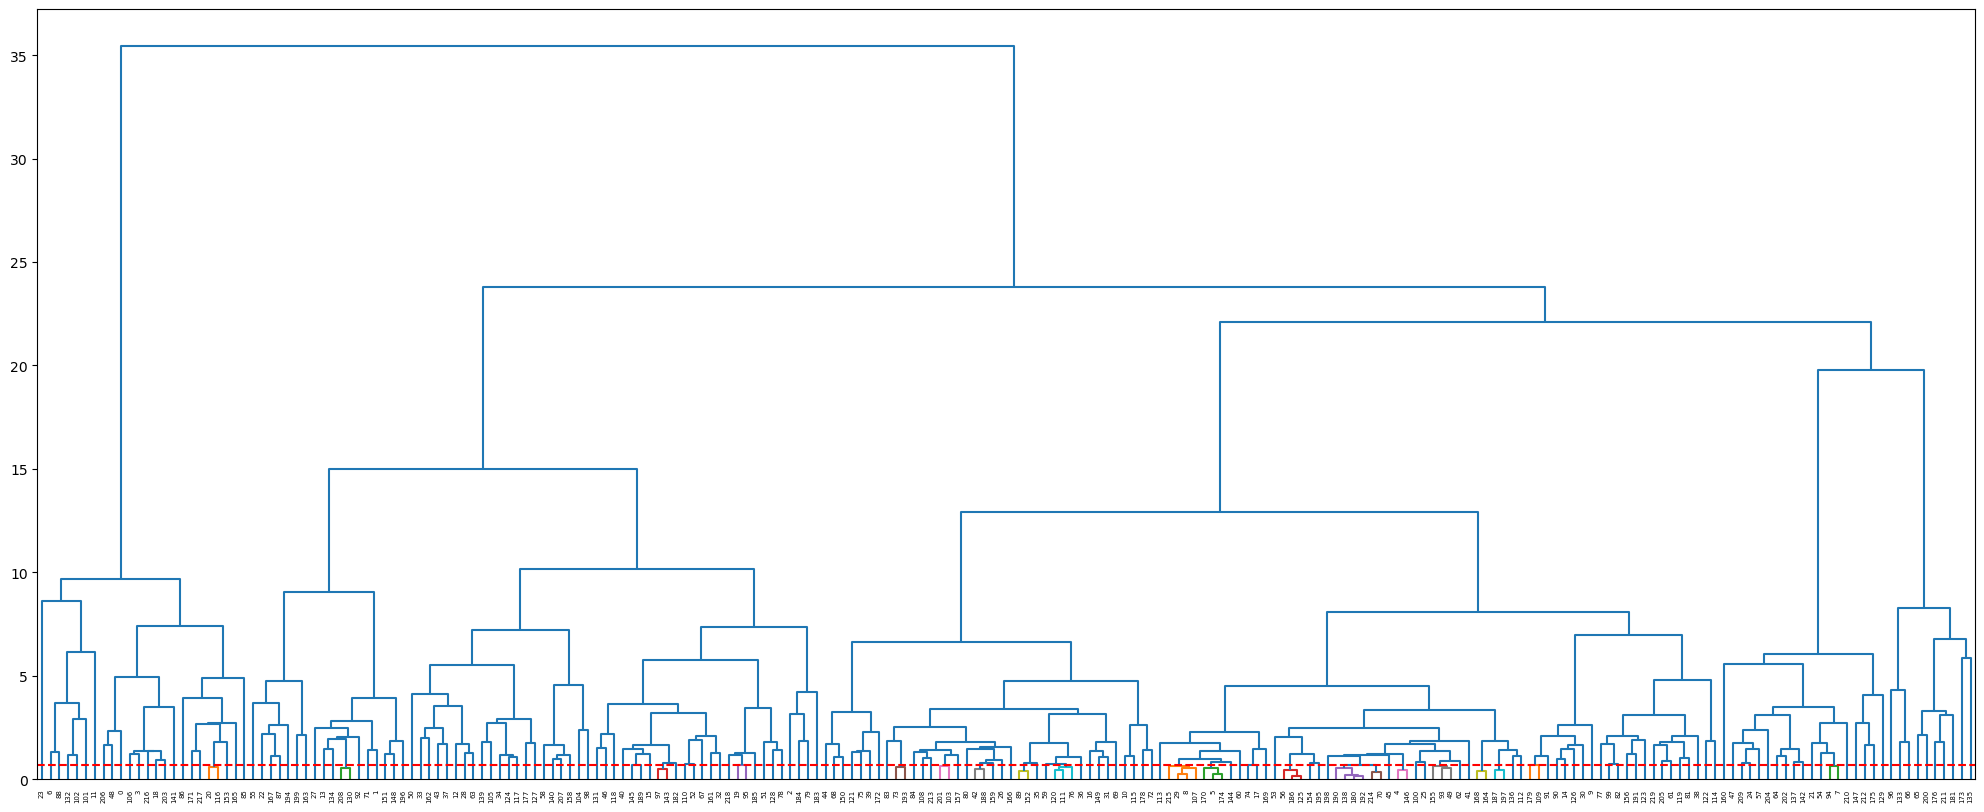

In [73]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = 0.7)
plt.axhline(y=.7, c='r', linestyle='--')

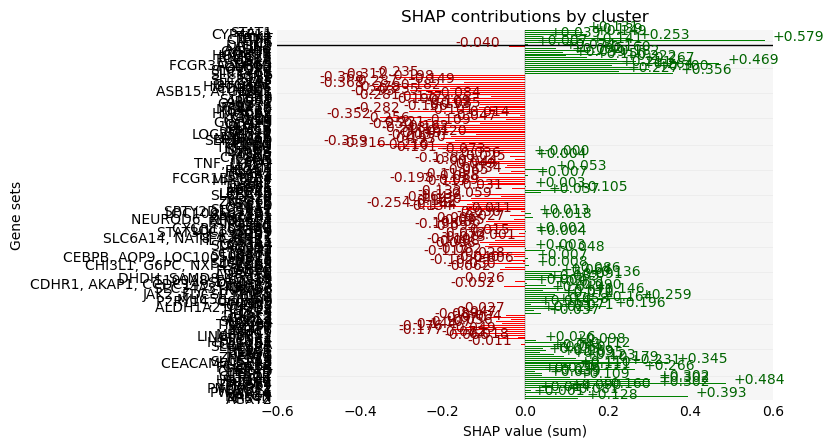

In [74]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
plt.axhline(7.45,linewidth=1., color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe;
clusters correspond to above dendrogram from left to right;
can choose threshold to get more / fewer clusters

In [75]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")

### Example: CD no ulcer patients

In [76]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_plain = linkage(df_cd_plain.T, 'ward', metric='euclidean', optimal_ordering=True)

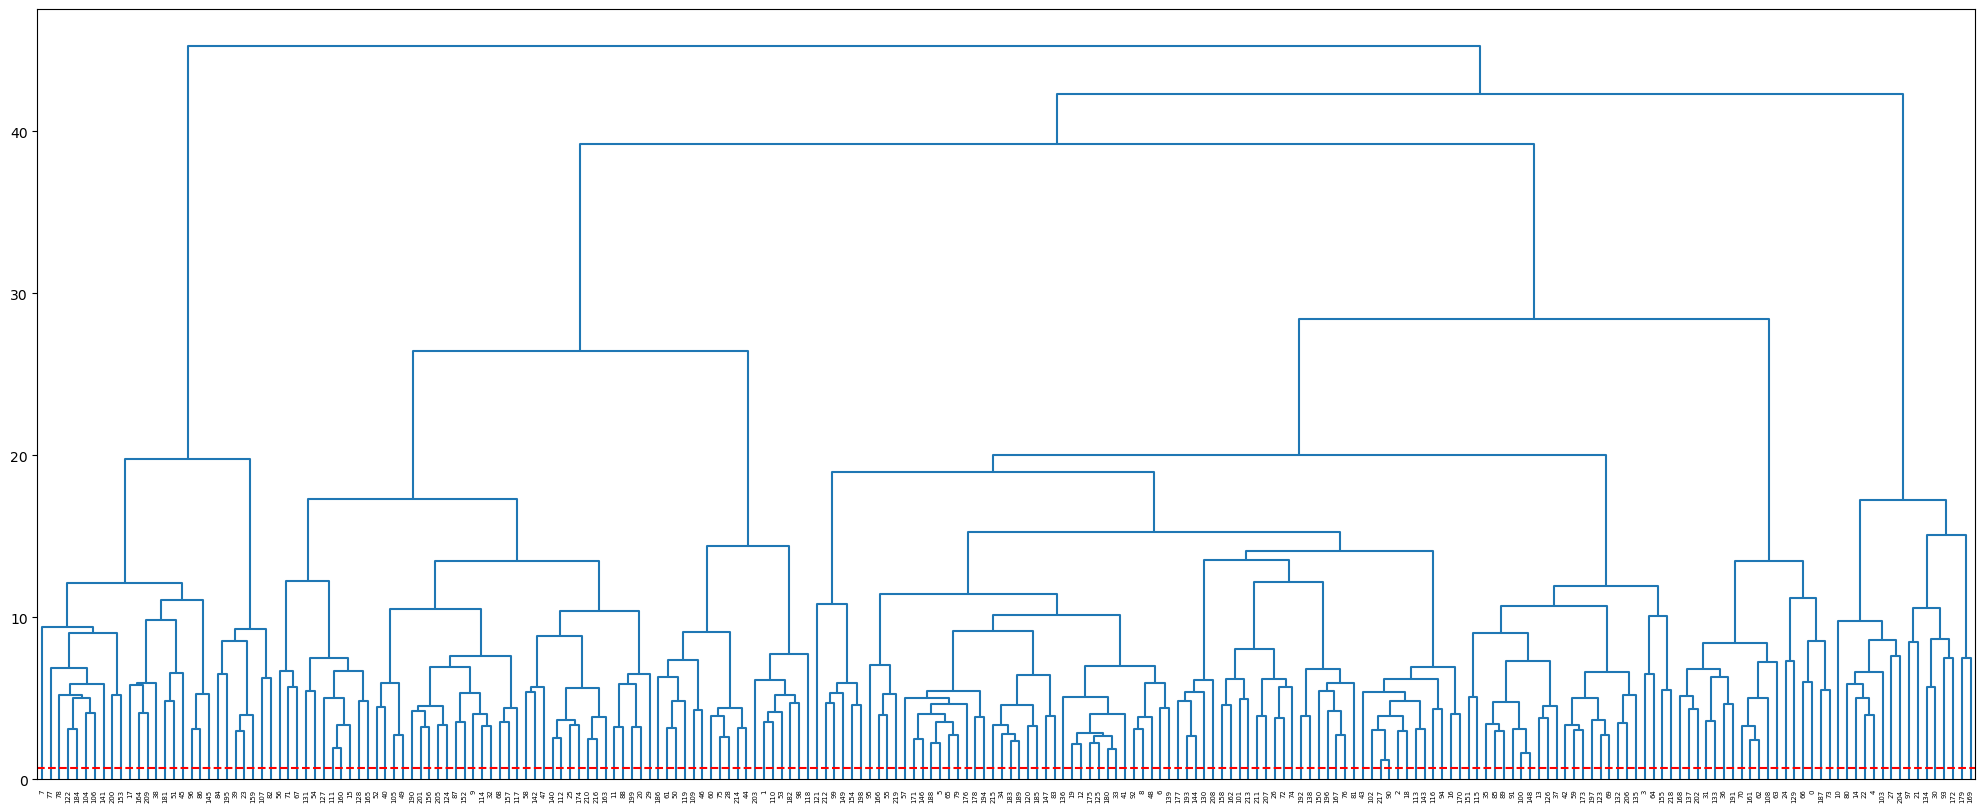

In [77]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold = .8)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [78]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([  7,  77,  78, 122, 184, 104, 106, 141, 200, 153,  17, 164, 209,
        38, 181,  51,  45,  96,  86, 145,  84, 195,  39,  23, 159, 107,
        82,  56,  71,  67, 131,  54, 127, 111, 160,  15, 128, 165,  52,
        40, 105,  49, 190, 201, 156, 205, 124,  87, 152,   9, 114,  32,
        68, 157, 117,  58, 142,  47, 140, 112,  25, 174, 210, 216, 163,
        11,  88, 199,  20,  29, 186,  61,  50, 119, 109,  46,  60,  75,
        28, 214,  44, 203,   1, 110,  53, 182,  98, 118, 121, 212,  99,
       149, 154, 198,  95, 166,  55, 219,  57, 171, 146, 188,   5,  65,
        79, 176, 178, 194, 215,  34, 183, 189, 120, 185, 147,  83, 136,
        19,  12, 175, 125, 180,  33,  41,  92,   8,  48,   6, 139, 177,
       193, 144, 130, 208, 158, 162, 101, 213, 211, 207,  26,  72,  74,
       192, 138, 150, 196, 167,  76,  81,  43, 102, 217,  90,   2,  18,
       113, 143, 116,  94,  16, 170, 151, 115,  35,  85,  89,  91, 100,
       148,  13, 126,  37,  42,  59, 173, 197, 123,  69, 132, 20

In [79]:
df_cd_plain.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'HDLBP', 'PIAS4', 'ADH1B', 'LOC100507531', 'FAM83A', 'NXF4', 'RNF125',
       'DARS', 'DNAI1', 'MBTPS1'],
      dtype='object', length=220)

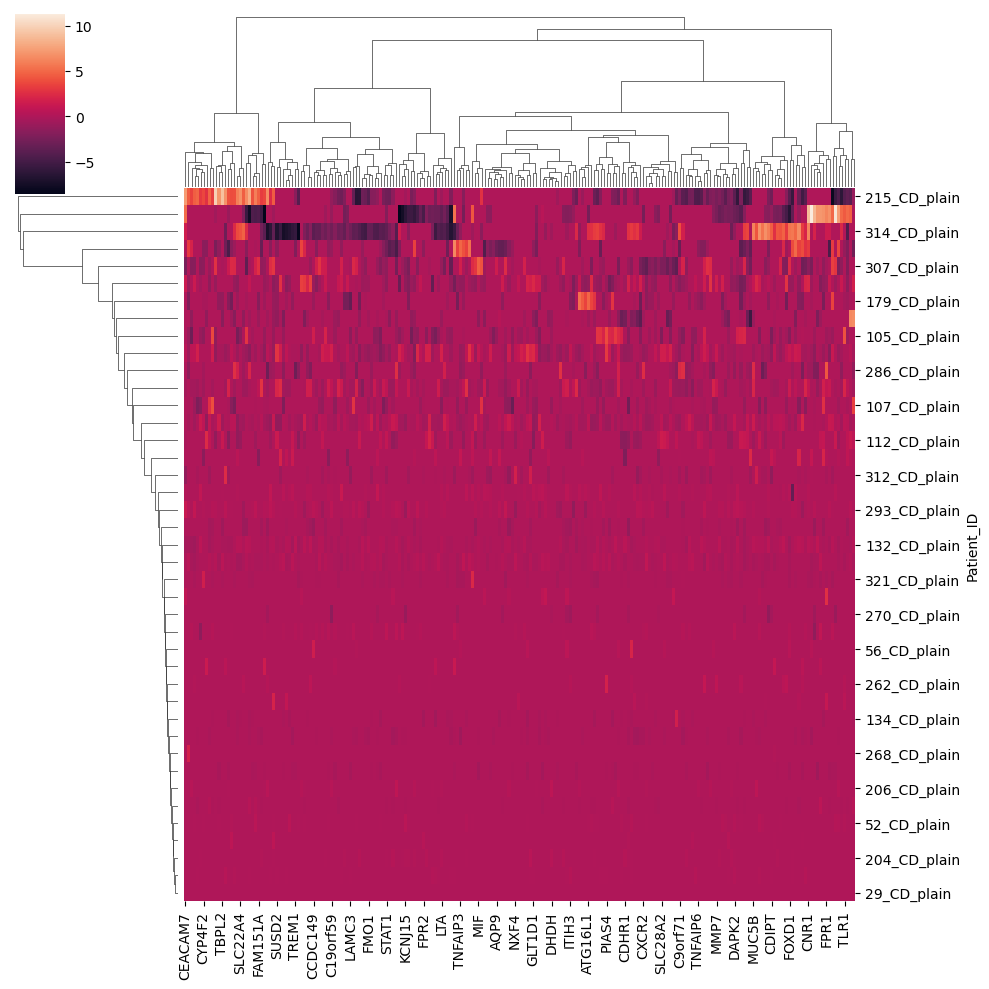

In [80]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_plain, col_linkage=gene_cluster_cd_plain)

## Aggregate bar plot, showing potential gene modules alongside SHAP contributions

In [81]:
gene_cluster_cd_plain

array([[217.        ,  90.        ,   1.21295271,   2.        ],
       [100.        , 148.        ,   1.59442406,   2.        ],
       [180.        ,  33.        ,   1.83332021,   2.        ],
       [111.        , 160.        ,   1.90561858,   2.        ],
       [ 19.        ,  12.        ,   2.17013329,   2.        ],
       [188.        ,   5.        ,   2.20395226,   2.        ],
       [175.        , 125.        ,   2.21685146,   2.        ],
       [183.        , 189.        ,   2.34046774,   2.        ],
       [161.        ,  62.        ,   2.4307417 ,   2.        ],
       [171.        , 146.        ,   2.47307309,   2.        ],
       [210.        , 216.        ,   2.48385839,   2.        ],
       [140.        , 112.        ,   2.51302531,   2.        ],
       [ 75.        ,  28.        ,   2.59210096,   2.        ],
       [226.        , 222.        ,   2.64028259,   4.        ],
       [193.        , 144.        ,   2.64863873,   2.        ],
       [ 65.        ,  79

In [82]:
cluster_labels = fcluster(gene_cluster_cd_plain, .8, criterion='distance')
# cluster_labels = fcluster(gene_cluster_cd_plain, 8, criterion='maxclust')
cluster_labels.shape

(220,)

In [83]:
leaders(gene_cluster_cd_plain, cluster_labels)

(array([122, 184, 104, 106,  78, 141,  77, 200, 153,   7, 164, 209,  17,
         38, 181,  51,  45,  96,  86, 145,  84, 195,  39,  23, 159, 107,
         82,  71,  67,  56, 131,  54, 111, 160,  15, 127, 128, 165,  52,
         40, 105,  49, 201, 156, 190, 205, 124,  87, 152, 114,  32,   9,
         68, 157, 117,  58, 142,  47, 140, 112,  25, 174, 210, 216, 163,
         11,  88, 199,  20,  29,  61,  50, 119, 186, 109,  46,  75,  28,
         60, 214,  44,   1, 110,  53, 182,  98, 203, 118, 212,  99, 149,
        154, 198, 121, 166,  55, 219,  95, 171, 146, 188,   5,  65,  79,
        176,  57, 178, 194, 183, 189,  34, 215, 120, 185, 147,  83,  19,
         12, 175, 125, 180,  33,  41, 136,  92,   8,  48,   6, 139, 193,
        144, 177, 130, 208, 158, 162, 101, 213, 211, 207,  26,  72,  74,
        192, 138, 167,  76, 196, 150,  81, 217,  90, 102,   2,  18, 113,
        143,  43, 116,  94,  16, 170, 151, 115,  85,  89,  35, 100, 148,
         91,  13, 126,  37,  59, 173,  42, 123,  69

In [84]:
leader_ids = leaders(gene_cluster_cd_plain, cluster_labels)[1]
leader_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [85]:
cluster_labels

array([202,  82, 154, 183, 206, 102, 128,  10, 126,  52, 212,  66, 118,
       171, 207,  35, 161,  13, 155, 117,  69, 214, 205,  24, 199,  61,
       141, 210,  78,  70, 216, 190,  51, 122, 111, 167, 192, 173,  14,
        23,  40, 123, 176, 158,  81,  17,  76,  58, 127,  42,  72,  16,
        39,  84,  32,  96,  30, 106,  56, 174,  79,  71, 195, 198, 184,
       103, 201,  29,  53, 178, 196,  28, 142, 204, 143,  77, 147,   7,
         5, 104, 208, 150,  27, 116,  21, 165,  19,  48,  67, 166, 152,
       170, 125, 217, 160,  98,  18, 213,  86,  90, 168, 137, 153, 209,
         3,  41,   4,  26, 197,  75,  83,  33,  60, 156,  50, 164, 159,
        55,  88,  73, 113,  94,   1, 177,  47, 120, 172,  36,  37, 200,
       133,  31, 180, 191, 215, 182, 124, 187, 145, 129,  59,   6,  57,
       157, 131,  20, 100, 115, 169,  91, 149, 163,  49,   9,  92, 185,
        44,  54, 135,  25,  34, 194, 136,  65,  11,  38,  95, 146, 189,
       220, 162,  99, 218, 175,  62, 119, 105, 132, 107, 219, 12

In [86]:
gene_df = df_cd_plain.describe().T
gene_df['gene_symbol']  = df_cd_plain.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,41.0,0.114193,1.405865,-3.175340,0.000000,0.0,0.0,6.468611,AADAC,202
APOA1,41.0,-0.321704,1.083797,-5.367101,0.000000,0.0,0.0,0.709955,APOA1,82
APOA4,41.0,-0.180912,0.533795,-2.321972,-0.089926,0.0,0.0,0.835693,APOA4,154
APOB,41.0,-0.360060,1.157305,-4.119777,-0.232456,0.0,0.0,1.987536,APOB,183
APOC3,41.0,0.168939,1.186883,-1.959623,0.000000,0.0,0.0,7.082206,APOC3,206
...,...,...,...,...,...,...,...,...,...,...
NXF4,41.0,0.024483,0.386047,-1.077334,0.000000,0.0,0.0,1.744049,NXF4,112
RNF125,41.0,-0.191128,0.815058,-4.493126,0.000000,0.0,0.0,1.017954,RNF125,64
DARS,41.0,-0.124561,0.371984,-1.924802,0.000000,0.0,0.0,0.220299,DARS,151
DNAI1,41.0,-0.395538,1.283686,-5.449266,0.000000,0.0,0.0,2.281351,DNAI1,186


In [87]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,0.114193,202,AADAC
APOA1,-0.321704,82,APOA1
APOA4,-0.180912,154,APOA4
APOB,-0.360060,183,APOB
APOC3,0.168939,206,APOC3
...,...,...,...
NXF4,0.024483,112,NXF4
RNF125,-0.191128,64,RNF125
DARS,-0.124561,151,DARS
DNAI1,-0.395538,186,DNAI1


In [88]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,0.114193,202,AADAC
APOA1,-0.321704,82,APOA1
APOA4,-0.180912,154,APOA4
APOB,-0.360060,183,APOB
APOC3,0.168939,206,APOC3
...,...,...,...
NXF4,0.024483,112,NXF4
RNF125,-0.191128,64,RNF125
DARS,-0.124561,151,DARS
DNAI1,-0.395538,186,DNAI1


In [89]:
agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,0.066120,1,[CLEC5A]
2,0.064846,1,[TPRKB]
3,-0.022625,1,[CUBN]
4,-0.040690,1,[CYP4F2]
5,-0.023720,1,[SELE]
...,...,...,...
216,-0.051950,1,[CXCL3]
217,0.141854,1,[TLR1]
218,-0.214447,1,[OR9A4]


In [90]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,0.066120,1,[CLEC5A],CLEC5A
2,0.064846,1,[TPRKB],TPRKB
3,-0.022625,1,[CUBN],CUBN
4,-0.040690,1,[CYP4F2],CYP4F2
5,-0.023720,1,[SELE],SELE
...,...,...,...,...
216,-0.051950,1,[CXCL3],CXCL3
217,0.141854,1,[TLR1],TLR1
218,-0.214447,1,[OR9A4],OR9A4


In [91]:
sorted_idxs = get_idx_order(dn_ids, df_cd_plain, agg_df)

In [92]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
10,0.066120,1,[CLEC5A],CLEC5A
7,0.064846,1,[TPRKB],TPRKB
5,-0.022625,1,[CUBN],CUBN
1,-0.040690,1,[CYP4F2],CYP4F2
2,-0.023720,1,[SELE],SELE
...,...,...,...,...
216,-0.051950,1,[CXCL3],CXCL3
217,0.141854,1,[TLR1],TLR1
218,-0.214447,1,[OR9A4],OR9A4
219,0.210327,1,[JOSD2],JOSD2


In [93]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-0.040690,1,[CYP4F2],CYP4F2
2,-0.023720,1,[SELE],SELE
3,0.042528,1,[FCRL3],FCRL3
4,0.078147,1,[CXCL5],CXCL5
5,-0.022625,1,[CUBN],CUBN
...,...,...,...,...
216,-0.051950,1,[CXCL3],CXCL3
217,0.141854,1,[TLR1],TLR1
218,-0.214447,1,[OR9A4],OR9A4
219,0.210327,1,[JOSD2],JOSD2


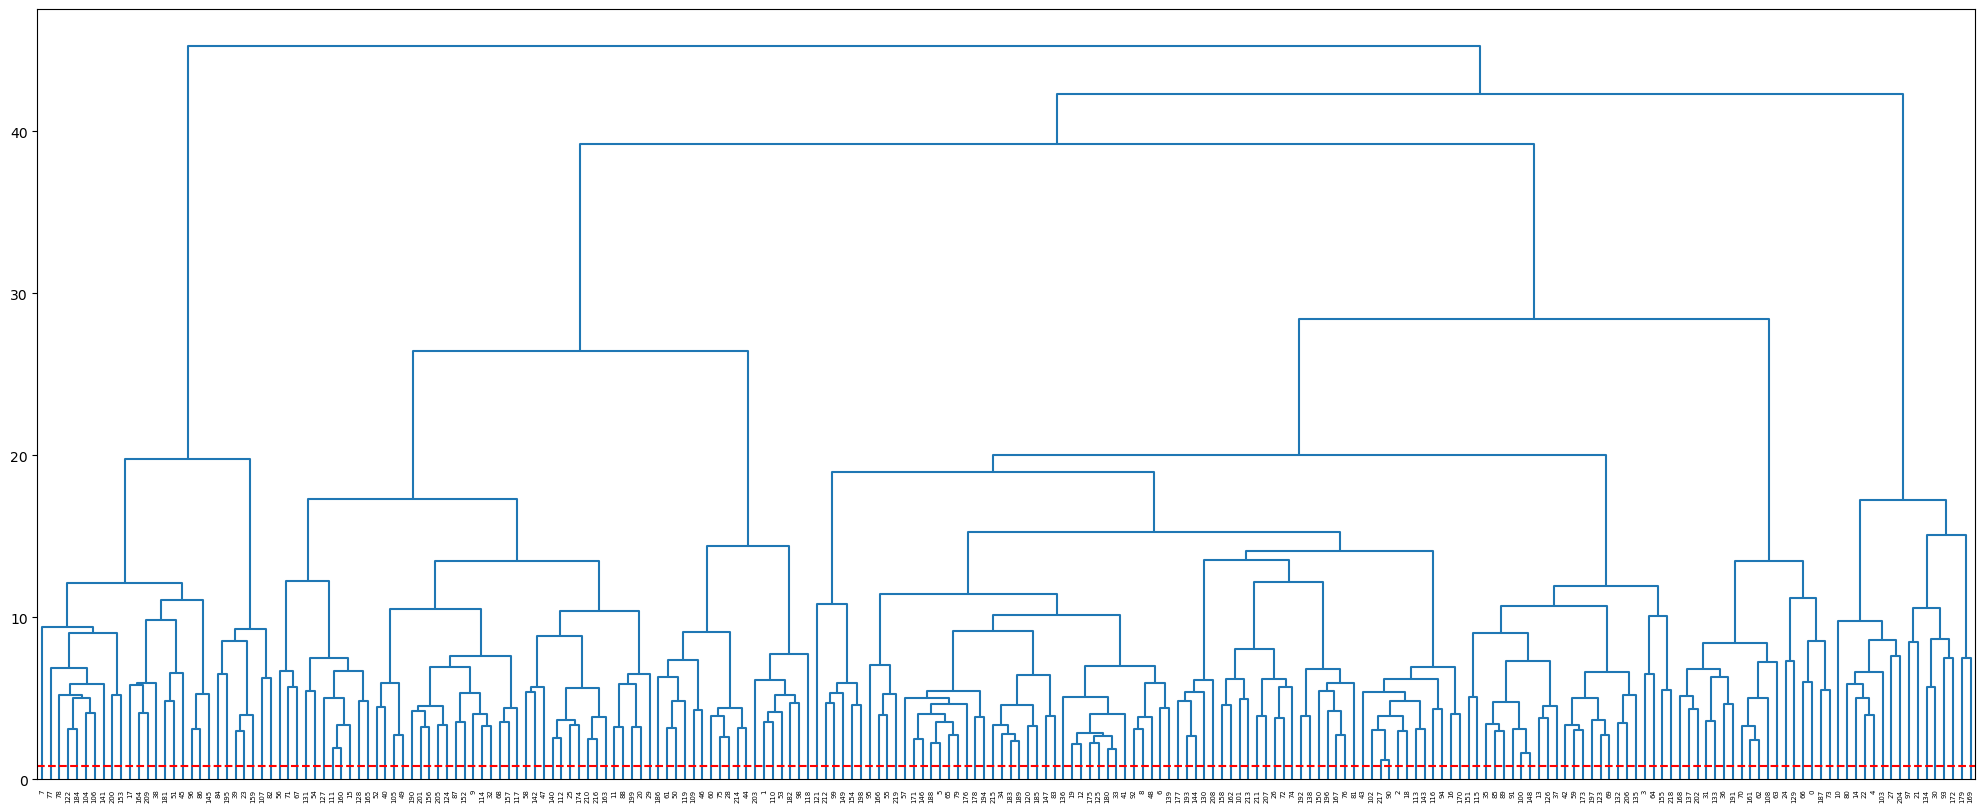

In [94]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold=.8, get_leaves=True)
plt.axhline(y=.8, c='r', linestyle='--')

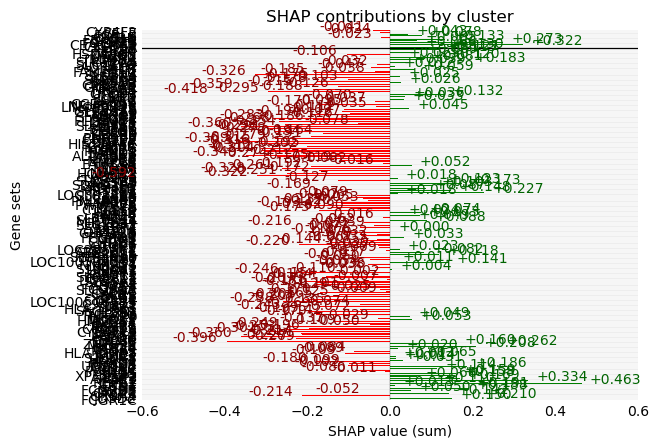

In [95]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
size = fig.get_size_inches()[1]
plt.axhline(size + .045*size,linewidth=.9, color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe
clusters correspond to above dendrogram from left to right
can choose threshold to get more / fewer clusters

In [96]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")